In [299]:
import cv2 
import numpy as np
import matplotlib.pyplot as plt
import copy
import math

In [300]:
class Tile:
    
    def __init__(self):
        self.ID = -1
        
        self.possibilities = set()
        
        self.collapsed = False
        self.propagated = False
        self.row = -1
        self.column = -1
    
    def entropy(self):
        return len(self.possibilities)
    
    def setNeighborPossibilities(self, neighborTile, direction, corpus):
        if neighborTile.collapsed == False: 
            if self.ID == -1:
                cumulative_posibilities = set()
                for pos in self.possibilities:
                    temp_possibilities = corpus[pos][direction]
                    cumulative_posibilities.update(temp_possibilities)
                neighborTile.possibilities = cumulative_posibilities
            else:
                neighborTile.possibilities = neighborTile.possibilities.intersection(corpus[self.ID][direction])
    

In [301]:
a = {1,2,3,4,5}
b = {3,4,5}
c = set()

In [302]:
a_b = a & b
print(a_b)

{3, 4, 5}


In [303]:
a = a.intersection(b)

print(a)


{3, 4, 5}


In [304]:
class Map():
    def __init__(self, image, tile_size):
        self.image = image
        self.tile_size = tile_size
        
        self.w = image.shape[0]
        self.h = image.shape[1]
        
        def get_tiles(image, w, h, tile_size):
            tiles = [
            image[x:x+tile_size,y:y+tile_size,:] 
            for x in range(0,w, tile_size) 
            for y in range(0,h,tile_size)
            ]
            return tiles
        
        self.tiles = get_tiles(self.image, self.w, self.h, self.tile_size)
        
        def get_hash_tiles(tiles):
            hashed_tiles = [pHash(tile) for tile in tiles]  
            return hashed_tiles
        
        def pHash(cv_image):
            imgg = cv2.cvtColor(cv_image, cv2.COLOR_BGR2RGB);
            h=cv2.img_hash.pHash(imgg) # 8-byte hash
            pH=int.from_bytes(h.tobytes(), byteorder='big', signed=False)
            return pH
        
        self.hashed_tiles = get_hash_tiles(self.tiles)
        
        self.unique_hashes = list(dict.fromkeys(self.hashed_tiles))
        


        self.hash_int_dict = dict([(self.unique_hashes[i], i) for i in range(len(self.unique_hashes))])
        self.hash_tile_dict = dict(zip(self.hashed_tiles, self.tiles))
        self.int_tile_dict = dict([(self.hash_int_dict[i], self.hash_tile_dict[i]) for i in self.unique_hashes])
        
        self.int_tiles = [self.hash_int_dict[hash] for hash in self.hashed_tiles]
        
        self.unique_ints = list(dict.fromkeys(self.int_tiles))
        
        
        def get_corpus():
            matrix_tiles = np.array(self.int_tiles).reshape((self.h//self.tile_size, self.w//self.tile_size))
            
            sequence = {}

            for i in range((self.h//self.tile_size)):
                for j in range((self.w//self.tile_size)):
                    if matrix_tiles[i,j] not in sequence:
                        sequence[matrix_tiles[i,j]] = {
                            0 : set(),
                            1 : set(),
                            2 : set(),
                            3 : set()
                        }
                    if i >  0:
                        sequence[matrix_tiles[i,j]][0].add(matrix_tiles[(i - 1), j])
                    if j <  self.w//self.tile_size - 1:
                        sequence[matrix_tiles[i,j]][1].add(matrix_tiles[i, (j + 1)])
                    if i <  self.h//self.tile_size - 1:
                        sequence[matrix_tiles[i,j]][2].add(matrix_tiles[(i + 1), j])
                    if j > 0:
                        sequence[matrix_tiles[i,j]][3].add(matrix_tiles[i, (j - 1)])
            
            return sequence
        
        self.corpus = get_corpus()
        

(384, 512)


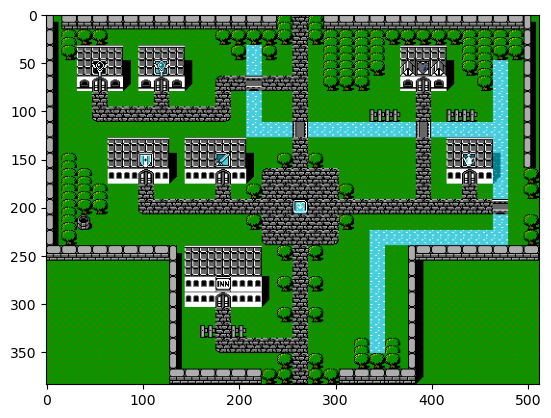

In [315]:
dq_level = cv2.imread("images/NES - Final Fantasy - Corneria.png")
print(dq_level.shape[0:2])
plt.imshow(dq_level[:,:,::-1])
plt.show()

In [317]:
dq_map = Map(dq_level, 16)

dq_map.corpus

{0: {0: {1, 4}, 1: {1, 6, 9}, 2: {5, 7, 8}, 3: {5}},
 1: {0: {4, 8}, 1: {1, 2, 5}, 2: {0, 3, 5, 6, 7, 8}, 3: {0, 1, 3, 7}},
 2: {0: {5, 7, 8}, 1: {2, 3, 7, 8, 19}, 2: {8, 34}, 3: {1, 2, 5}},
 3: {0: {1, 3, 4, 5, 7, 8, 9, 11, 18, 30},
  1: {1, 3, 4, 6, 7, 8, 10, 33, 34},
  2: {3, 4, 7, 8, 10, 20, 30},
  3: {2, 3, 4, 6, 7, 8, 10}},
 4: {0: {3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 15, 16, 18, 20, 25, 30, 34},
  1: {3, 4, 7, 8, 21, 23, 24, 32},
  2: {0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 17, 19, 22, 25, 32, 33},
  3: {3, 4, 7, 8, 20, 21, 22, 24, 32}},
 5: {0: {0, 1, 4, 5, 7, 8, 22},
  1: {0, 2, 5},
  2: {2, 3, 4, 5, 7, 8, 10},
  3: {1, 5}},
 6: {0: {1, 4, 8, 9, 11, 13, 14, 17, 18, 19},
  1: {3, 6, 7, 8, 11, 30},
  2: {4, 7, 8, 9, 10, 15, 16, 17, 18, 25},
  3: {0, 3, 6, 7, 8}},
 7: {0: {0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 17, 18, 30, 34},
  1: {1, 3, 4, 6, 7, 8, 9, 10, 34},
  2: {2, 3, 4, 5, 7, 8, 9, 10, 11, 21, 30, 34},
  3: {2, 3, 4, 6, 7, 8, 10, 13}},
 8: {0: {0,
   1,
   2,
   3,
   4,
   

In [318]:
class Grid:
    def __init__(self, width, height, img, t_size):
        self.width = width
        self.height = height
        self.t_size = t_size
        self.map_data = Map(img, t_size)
        self.grid = []
    
    def is_fully_collapsed(self):
        for row in self.grid:
            for tile in row:
                if tile.collapsed == False:
                    return False
        return True
        
    def initialize(self):
        for i in range(self.width):
            self.grid.append([])
            for j in range(self.height):
                tile = Tile()
                tile.possibilities.update(self.map_data.unique_ints)
                tile.row = i
                tile.column = j
                self.grid[i].append(tile)
                
            
                
                
    
    def heuristic_pick(self):
        low_entropy = math.inf
        pick = 0,0
        for i in range(self.width):
            for j in range(self.height):
                currentTile = self.getTile(i, j)
                if currentTile.entropy() <= low_entropy and currentTile.collapsed == False:
                   low_entropy = currentTile.entropy()
                   pick = i,j
        return pick
    
    def observe(self, tile):
        if tile.collapsed == False:
            tile.ID = np.random.choice(list(tile.possibilities))
            tile.possibilities = {tile.ID}
            tile.collapsed = True
    
    def propagation(self, startTile):
        corpus = self.map_data.corpus
        for row in self.grid:
            for tile in row:
                tile.propagated = False
        propagation_queue = []
        
        def propQueue(tile):
            if tile.propagated == False:
                propagation_queue.append(tile)
                tile.propagated = True
                
        propQueue(startTile)
        
        while propagation_queue:
            currentTile = propagation_queue.pop(0)
            if currentTile.row > 0:
                upTile = self.getTopNeighbor(currentTile)
                currentTile.setNeighborPossibilities(upTile, 0, self.map_data.corpus)
                propQueue(upTile)
            if currentTile.column < self.width - 1:
                rightTile = self.getRightNeighbor(currentTile)
                currentTile.setNeighborPossibilities(rightTile, 1, self.map_data.corpus)
                propQueue(rightTile)
            if currentTile.row < self.height - 1:
                downTile = self.getBotNeighbor(currentTile)
                currentTile.setNeighborPossibilities(downTile, 2, self.map_data.corpus)
                propQueue(downTile)
            if currentTile.column > 0:
                leftTile = self.getLeftNeighbor(currentTile)
                currentTile.setNeighborPossibilities(leftTile, 3, self.map_data.corpus)
                propQueue(leftTile)
                    
            if currentTile.entropy() == 1:
                self.observe(currentTile)
                
    def WaveFunctionCollapse(self):
        i = np.random.randint(0, self.width)
        j = np.random.randint(0, self.height)
        self.initialize() 
        while self.is_fully_collapsed() == False:
            currentTile = self.getTile(i, j)
            print (i,j) 
            self.observe(currentTile)
            self.propagation(currentTile)
            # self.updatePossibilities()
  
            i, j = self.heuristic_pick()
    
    def getTile(self, row, column):
        return self.grid[row][column]
    
    def getTopNeighbor(self, tile):
        if tile.row > 0:
            return self.grid[tile.row - 1][tile.column]
        
    def getRightNeighbor(self, tile):
        if tile.column < self.width - 1:
            return self.grid[tile.row][tile.column + 1]
        
    def getBotNeighbor(self, tile):
        if tile.row < self.height - 1:
            return self.grid[tile.row + 1][tile.column]
        
    def getLeftNeighbor(self, tile):
        if tile.column > 0:
            return self.grid[tile.row][tile.column - 1]
        
    def getTilePossibilities(self, tile):
        if tile is not None:
            return tile.possibilities
        else:
            return set(self.map_data.int_tiles)

        
                

                        
    def get_grid_values(self):
        grid_ids = [[tile.ID for tile in i] for i in self.grid]
        
        return grid_ids
    def get_grid_possibilities(self):
        grid_pos = [[tile.possibilities for tile in i] for i in self.grid]
        
        return grid_pos

In [323]:
wfc = Grid(width=10, height=10, img=dq_level, t_size=16)
# wfc.initialize()
# for i in wfc.grid:
#     for j in i:
#         print(j.possibilities)
#         print(j.entropy())}
#         print(j.position)
wfc.WaveFunctionCollapse()

3 5
3 3
2 4
2 6
4 6
5 6
1 6
3 7
4 7
1 7
3 8
1 8
2 8
3 9
4 9
2 9
5 8
0 9
5 9
1 5
0 8
4 4
0 7
5 5
0 6
6 6
6 5
6 4
0 5
7 5
6 9
7 6
6 8
7 7
6 7
8 7
7 8
8 6
8 5
8 3
5 4
9 4
8 9
9 6
9 8
9 7
9 3
1 4
1 2
0 3
0 2
7 3
7 1
4 3
6 2
6 0
9 2
8 2
5 3
5 0
5 2
5 1
3 2
4 0
4 1
2 2
3 0
4 2
3 1
9 1
8 0
9 0
2 1
0 0
1 0


In [324]:
wfc.get_grid_possibilities()

[[{25}, {8}, {15}, {9}, {8}, {4}, {4}, {8}, {15}, {13}],
 [{4}, {8}, {11}, {11}, {14}, {11}, {6}, {3}, {8}, {4}],
 [{11}, {12}, {11}, {8}, {6}, {8}, {11}, {8}, {3}, {33}],
 [{4}, {7}, {8}, {6}, {11}, {14}, {11}, {11}, {3}, {11}],
 [{11}, {8}, {6}, {8}, {6}, {6}, {30}, {35}, {30}, {19}],
 [{11}, {13}, {8}, {11}, {8}, {3}, {3}, {8}, {9}, {8}],
 [{11}, {8}, {9}, {11}, {34}, {17}, {4}, {8}, {8}, {20}],
 [{11}, {28}, {11}, {29}, {8}, {30}, {18}, {17}, {20}, {4}],
 [{6}, {8}, {8}, {8}, {11}, {14}, {17}, {8}, {4}, {33}],
 [{8}, {6}, {8}, {34}, {10}, {6}, {7}, {3}, {3}, {8}]]

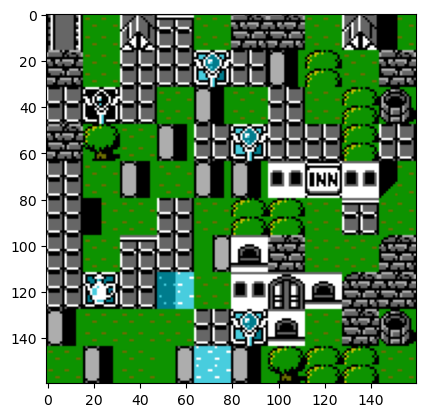

In [325]:

map_tiles = copy.copy(wfc.get_grid_values())
for i in range(len(map_tiles)):
    for j in range(len(map_tiles[0])): 
        map_tiles[i][j] = wfc.map_data.int_tile_dict[map_tiles[i][j]]
level_concat = []
for i in map_tiles:
    level_concat.append(cv2.hconcat(i))
    
final_level = cv2.vconcat(level_concat)


plt.imshow(final_level[:,:,::-1])
plt.show()